## CAPM Regression of Returns to Find Alpha & Beta ##
 **The Capital Asset Pricing Model (CAPM):**
 
 $$
 \mathbb{E}[R_i] = r_f + \beta_i \big(\mathbb{E}[R_m] - r_f\big)
 $$
 
 - $\mathbb{E}[R_i]$ : Expected return of asset $i$
 - $r_f$ : Risk-free rate   
 - $\beta_i$ : Sensitivity (“beta”) of $i$ to market returns
 - $\mathbb{E}[R_m]$ : Expected market return
 - $\big(\mathbb{E}[R_m] - r_f\big)$ : Market risk premium
 
Goal of this project: Run a regression to see how much of the fund's returns are explained by the market

Reference: Sharpe, W.F. (1964). "Capital Asset Prices: A Theory of Market Equilibrium under Conditions of Risk." Journal of Finance.

If CAPM is true, everything is just varying degrees of market exposure - in reality this is not the case!
 
 The standard CAPM model (above) has no "alpha" term—CAPM assumes the market is efficient, so on average, all assets plot exactly on the line: 
 
 $$\mathbb{E}[R_i] = r_f + \beta_i (\mathbb{E}[R_m] - r_f)$$
 
 In real data, we often observe persistent deviations from this line. 
 
 We capture these deviations with an **"alpha"** term by amending the regression equation:
 
 $$
 R_i = \alpha_i + r_f + \beta_i (R_m - r_f) + \varepsilon
 $$
 
 Here, $\alpha_i$ (alpha) measures the excess return of asset $i$ beyond what is predicted by beta and the market, after adjusting for risk-free rate. If $\alpha>0$, the asset or portfolio is "beating CAPM"; if $\alpha<0$, it's underperforming.



In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [232]:
# Pull historical data from yfinance starting from the year 2000
ticker = "^990100-USD-STRD"
market_data = yf.download(ticker, start="2000-01-01", multi_level_index=False) 
market_data['market_rets'] = market_data['Close'].pct_change()
market_data = market_data.dropna()
display(market_data.head())
display(market_data.tail())

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume,market_rets
Date,,,,,,
2000-01-04,1422.099976,1422.099976,1422.099976,1422.099976,0,0.000915
2000-01-05,1378.300049,1378.300049,1378.300049,1378.300049,0,-0.030799
2000-01-06,1359.500000,1359.500000,1359.500000,1359.500000,0,-0.013640
2000-01-07,1344.000000,1344.000000,1344.000000,1344.000000,0,-0.011401
2000-01-10,1375.800049,1375.800049,1375.800049,1375.800049,0,0.023661


,Close,High,Low,Open,Volume,market_rets
Date,,,,,,
2026-02-06,4529.000000,4534.000000,4446.200195,4449.100098,0,0.017273
2026-02-09,4570.799805,4577.899902,4527.399902,4528.000000,0,0.009229
2026-02-10,4570.500000,4591.200195,4566.700195,4571.399902,0,-0.000066
2026-02-11,4568.899902,4597.100098,4553.600098,4568.500000,0,-0.000350
2026-02-12,4578.509766,4579.750000,4570.759766,4571.859863,0,0.002103


In [233]:
#Get returns data (depends on fund)
fund_data = pd.read_csv("C:/Users/admin/Desktop/Python Projects/parkman-healthcare-partners_returns.csv")
fund_data = fund_data[['Date', 'Return']].dropna() #The column names must be "Date" and "Return" 

# Prepare fund returns
fund_data['Date'] = pd.to_datetime(fund_data['Date'])
fund_data = fund_data.set_index('Date').sort_index()
fund_data['Return'] = fund_data['Return'].str.rstrip('%').astype('float') / 100

display(fund_data.head())
display(fund_data.tail())

C:\Users\admin\AppData\Local\Temp\ipykernel_17496\717872865.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  fund_data['Date'] = pd.to_datetime(fund_data['Date'])


,Return
Date,
2019-06-30,0.000085
2019-07-31,-0.015400
2019-08-31,-0.028900
2019-09-30,-0.036700
2019-10-31,0.028000


,Return
Date,
2025-09-30,0.000246
2025-10-31,0.000187
2025-11-30,0.000344
2025-12-31,-0.000088
2026-01-31,-0.000120


In [234]:
#Get 10-year treasury bill data for each month
rf = pd.read_csv("C:/Users/admin/Desktop/Python Projects/10_yr_treasury_monthly.csv") #columns are "Date" and "Yield"
rf['Date'] = pd.to_datetime(rf['Date'])
rf = rf.set_index('Date')

#De-annualize it to monthly rate, change to decimal
rf['Yield'] = rf['Yield'] / 12 / 100
rf

,Yield
Date,
2026-01-30,0.003531
2025-12-31,0.003474
2025-11-28,0.003346
2025-10-31,0.003398
2025-09-30,0.003459
...,...
2000-05-31,0.005227
2000-04-28,0.005177
2000-03-31,0.005003


In [235]:
#get fund returns and market returns
fund_rets = fund_data['Return']

#Change this depending on the hedge fund returns data frequency
market_rets = market_data['market_rets'].resample('M').apply(lambda x: (1 + x).prod() - 1) #monthly
# market_rets = df['market_rets'].resample('D') #daily

# force all dates to the calendar month end
fund_rets.index = fund_rets.index.to_period('M').to_timestamp('M')
market_rets.index = market_rets.index.to_period('M').to_timestamp('M')
rf.index = rf.index.to_period('M').to_timestamp('M')

#SANITY CHECKS
market_rets.to_csv('market_returns.csv')
rf.to_csv('monthly_yield.csv')
fund_rets.to_csv('fund_returns.csv')

# Align series on common dates
df = pd.concat([fund_rets, market_rets, rf], axis = 1, join='inner')
df.columns = ['Return', 'Market Return', 'Risk Free']
df

C:\Users\admin\AppData\Local\Temp\ipykernel_17496\1459807395.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  market_rets = market_data['market_rets'].resample('M').apply(lambda x: (1 + x).prod() - 1) #monthly


,Return,Market Return,Risk Free
Date,,,
2019-06-30,0.000085,0.064555,0.001672
2019-07-31,-0.015400,0.004223,0.001679
2019-08-31,-0.028900,-0.022445,0.001248
2019-09-30,-0.036700,0.019406,0.001388
2019-10-31,0.028000,0.024541,0.001410
...,...,...,...
2025-09-30,0.000246,0.030878,0.003459
2025-10-31,0.000187,0.019435,0.003398
2025-11-30,0.000344,0.001822,0.003346


### Returns with risk-free rate ###

beta = 0.1500, alpha = 0.002726
mean alpha component = 0.002726
mean beta component  = 0.001300
R^2 = 0.116630


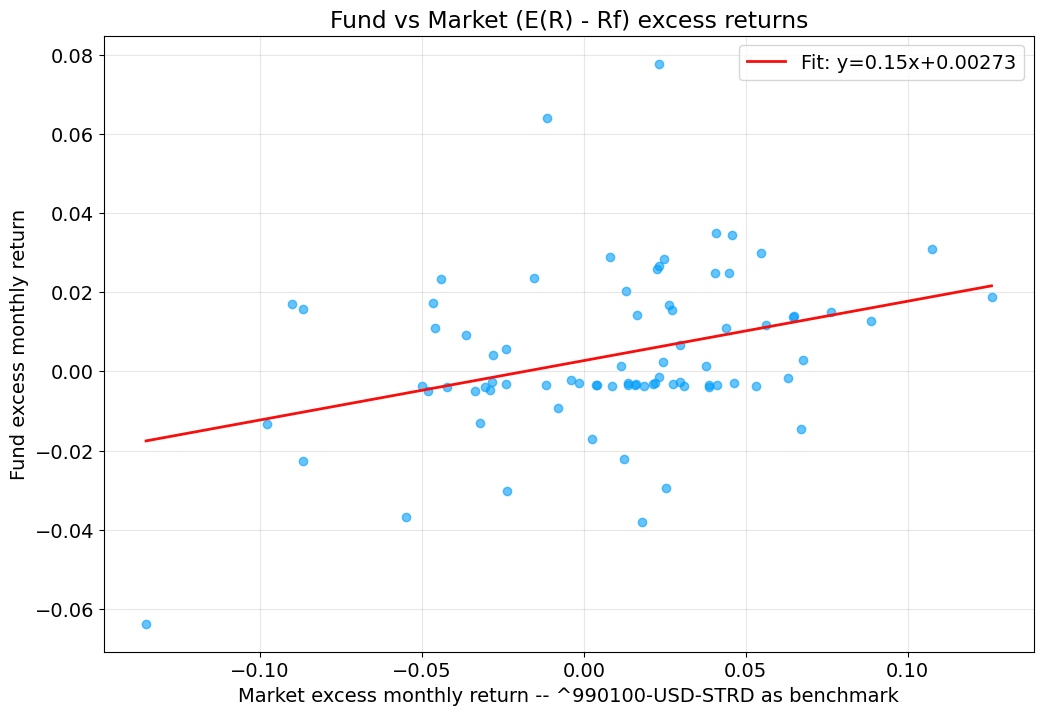

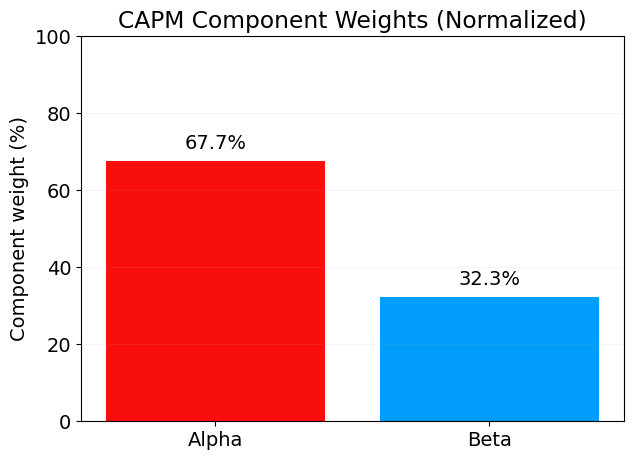

In [241]:
alpha_color = "#f90e0eff"
beta_color = '#009efb'

market_excess = df['Market Return'] - df['Risk Free']

fund_excess = df['Return'] - df['Risk Free']

# CAPM regression on excess returns: fund_excess = alpha + beta * market_excess
beta, alpha = np.polyfit(market_excess, fund_excess, 1)

# Mean components (no residual/noise term)
alpha_component = float(alpha)
beta_component = float(beta) * float(market_excess.mean())

print(f'beta = {beta:.4f}, alpha = {alpha:.6f}')
print(f'mean alpha component = {alpha_component:.6f}')
print(f'mean beta component  = {beta_component:.6f}')

# Normalize components (0-100%)
components = [alpha_component, beta_component]
components_nonneg = [max(0.0, float(x)) for x in components] #Set negative components to zero (can't plot)
components_sum = float(sum(components_nonneg))
if components_sum > 0:
    components_pct = [x / components_sum * 100.0 for x in components_nonneg]
else:
    components_pct = [0.0, 0.0]

# Scatter plot to display the fund's return corelation with market
x = market_excess.dropna() # x is a series
y = fund_excess.reindex(x.index).dropna()
x = x.reindex(y.index)

#find r squared for style points
y_hat = alpha + beta * x  
ss_res = ((y - y_hat) ** 2).sum()
ss_tot = ((y - y.mean()) ** 2).sum()
r2 = 1 - ss_res / ss_tot
print(f"R^2 = {r2:.6f}")

# Fitted line: y = alpha + beta * x
x_sorted = x.sort_values()
y_fit = alpha + beta * x_sorted
plt.figure(figsize=(12, 8))
plt.scatter(x, y, alpha=0.6, color=beta_color)
plt.plot(
    x_sorted,
    y_fit,
    color=alpha_color,
    linewidth=2,
    label=f"Fit: y={beta:.2f}x+{alpha:.5f}",
)
plt.xlabel(f"Market excess monthly return -- {ticker} as benchmark")
plt.ylabel("Fund excess monthly return")
plt.title("Fund vs Market (E(R) - Rf) excess returns")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot normalized alpha and beta (0-100%)

labels = ['Alpha', 'Beta']
colors = [alpha_color, beta_color]

plt.figure(figsize=(7, 5))
bars = plt.bar(labels, components_pct, color=colors)
plt.ylabel("Component weight (%)")
plt.title("CAPM Component Weights (Normalized)")
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.1)
for b in bars:
    h = b.get_height()
    plt.text(
        b.get_x() + b.get_width() / 2,
        h + 2,
        f"{h:.1f}%",
        ha="center",
        va="bottom",
    )
plt.show()

